# Лабораторна 1 - Fine-tuning: покращення роботи моделі

Виконав: Тивонюк Володимир ФБ-4/1мн

#### Завантаження необхідних бібліотек - буду використовувачи PyTorch

[dataset here](https://www.kaggle.com/datasets/orvile/sperm-morphology-image-data-set-smids?resource=download) Sperm Morphology Image Data Set (SMIDS)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import sklearn.metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Using device: cuda:0


Дефолт функція для підвантаження картинок

In [3]:
from PIL import Image, UnidentifiedImageError
import os
import matplotlib.pyplot as plt 


def load_bsp_as_pil(path):
    """
    Attempts to load a file using PIL and returns an RGB PIL Image.
    Handles potential UnidentifiedImageError if PIL doesn't recognize the format.
    You might need to investigate the *actual* .bsp format if this fails.
    """
    try:
        img = Image.open(path)
        img = img.convert('RGB')
        return img
    except UnidentifiedImageError:
        print(f"Error: PIL cannot identify image file format for: {path}")
        print("Please investigate the SMIDS dataset's documentation or source for details on how to load .bsp files.")
    except FileNotFoundError:
        print(f"Error: File not found at path: {path}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred loading {path}: {e}")
        raise

Визначаю трансформації (зміна розміру, аугментація, нормалізація) для тренувального, валідаційного та тестового наборів. 
Завантажую повний датасет за допомогою ImageFolder та нашої функції завантаження, розділяємо його на частини (train/val/test).

In [4]:
data_dir = 'SMIDS'
img_size = 224
batch_size = 32

if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"Data directory '{data_dir}' not found.")
print(f"Data directory '{data_dir}' found.")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_dataset = datasets.ImageFolder(
    data_dir,
    loader=load_bsp_as_pil, # Use custom loader
    transform=None # Apply transforms after splitting
)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Found {len(full_dataset)} images in {num_classes} classes: {class_names}")

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
print(f"Splitting: Train={train_size}, Val={val_size}, Test={test_size}")
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

Data directory 'SMIDS' found.
Found 3000 images in 3 classes: ['Abnormal_Sperm', 'Non-Sperm', 'Normal_Sperm']
Splitting: Train=2100, Val=450, Test=450


Клас-обгортка DatasetWrapper - для застосування визначених трансформацій до розділених частин датасету. Створюю DataLoaders для ефективного завантаження даних батчами під час навчання та оцінки.

In [5]:
class DatasetWrapper(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

train_dataset_transformed = DatasetWrapper(train_dataset, transform=data_transforms['train'])
val_dataset_transformed = DatasetWrapper(val_dataset, transform=data_transforms['val'])
test_dataset_transformed = DatasetWrapper(test_dataset, transform=data_transforms['test'])

Візуалка і ініціація даталоадерів

Dataset sizes: {'train': 2100, 'val': 450, 'test': 450}
DataLoaders created.


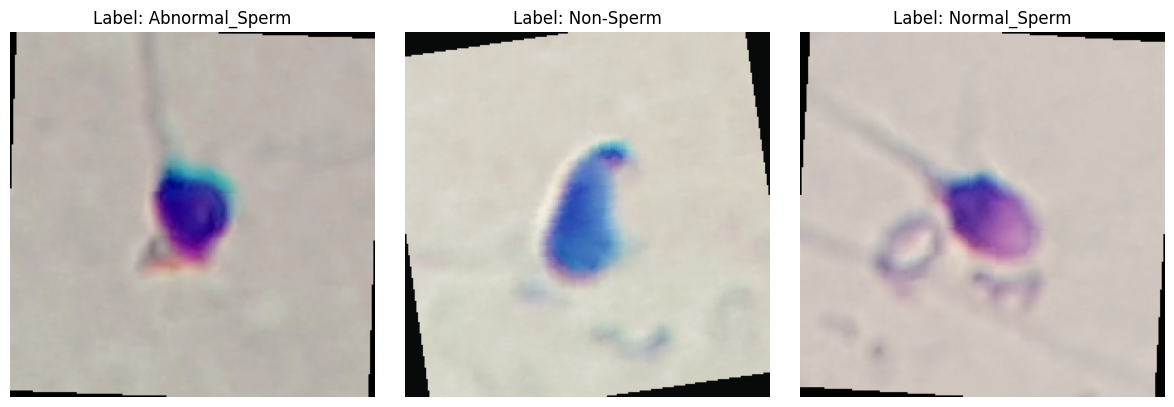

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader


dataloaders = {
    'train': DataLoader(train_dataset_transformed, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=0),
    'test': DataLoader(test_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=0)
}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
print("Dataset sizes:", dataset_sizes)
print("DataLoaders created.")

images_by_class = {}
indices_checked = 0
max_checks = len(train_dataset_transformed)

try:
    while len(images_by_class) < num_classes and indices_checked < max_checks:
        img_tensor, label_index = train_dataset_transformed[indices_checked]
        if label_index not in images_by_class:
            images_by_class[label_index] = img_tensor
        indices_checked += 1

    num_found = len(images_by_class)
    if num_found == 0:
        print("No images found in training set.")
    else:
        fig, axs = plt.subplots(1, num_found, figsize=(4 * num_found, 4))
        if num_found == 1:
            axs = [axs]

        plot_idx = 0
        # Sort by class index for consistent order, though not strictly necessary
        for label_index in sorted(images_by_class.keys()):
            img_tensor = images_by_class[label_index]
            label_name = class_names[label_index]

            img_display = img_tensor.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = np.clip(std * img_display + mean, 0, 1)

            ax = axs[plot_idx]
            ax.imshow(img_display)
            ax.set_title(f"Label: {label_name}")
            ax.axis('off')
            plot_idx += 1

        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"\nCould not visualize images: {e}")

model_ft_extract: Переднавчена модель, де заморожені всі згорткові шари 

model_scratch: Модель з випадковою ініціалізацією ваг 

model_ft_full: Переднавчена модель, де шари поки що не заморожені 
(останню модель додав пізніше, адже перша показала себе не дуже на даному датасеті)


In [7]:
def setup_model(num_classes, pretrained=True, feature_extract=True):
    if pretrained:
        print("Loading PRE-TRAINED ResNet18.")
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weights)
    else:
        print("Loading ResNet18 with RANDOM weights.")
        model = models.resnet18(weights=None)

    if feature_extract and pretrained:
        for param in model.parameters():
            param.requires_grad = False
    elif not feature_extract and pretrained: # Full fine-tuning case (
        print("Unfreezing ALL parameters for full fine-tuning.")
        for param in model.parameters():
            param.requires_grad = True 

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    print(f"Replaced final layer: Linear({num_ftrs}, {num_classes}).")

    if feature_extract and pretrained: 
         for param in model.fc.parameters():
              param.requires_grad = True

    return model, 224 # Input size

# Instantiate models
model_ft, input_size_ft = setup_model(num_classes, pretrained=True, feature_extract=True) # Feature extraction FT
model_ft = model_ft.to(device)

model_scratch, input_size_scratch = setup_model(num_classes, pretrained=False) # Train from scratch
model_scratch = model_scratch.to(device)

Loading PRE-TRAINED ResNet18.
Replaced final layer: Linear(512, 3).
Loading ResNet18 with RANDOM weights.
Replaced final layer: Linear(512, 3).


### 0. Функції евалюації та тренування для моделей

Функція тренувального циклу для моделей

In [8]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"\nStarting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            running_loss = 0.0
            running_corrects = 0
            loader = dataloaders[phase]
            num_samples = dataset_sizes[phase]

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler: scheduler.step()

            epoch_loss = running_loss / num_samples
            epoch_acc = running_corrects.double() / num_samples
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'  >> New best validation accuracy: {best_acc:.4f}')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model, history

Функція для евалюації моделей

In [9]:
def evaluate_model(model, loader, device, class_names):
    """Evaluates the model, returns metrics and plots confusion matrix."""
    model.eval()
    all_preds, all_labels = [], []
    print(f"\nEvaluating model on {len(loader.dataset)} samples...")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = sklearn.metrics.accuracy_score(all_labels, all_preds)
    report = sklearn.metrics.classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    cm = sklearn.metrics.confusion_matrix(all_labels, all_preds)

    print(f"\nEvaluation Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix'); plt.show()

    return accuracy, report, cm

### 1. Feature Extraction

Налаштування та запуск тренування для першого методу fine-tuning (Feature Extraction). Використовую переднавчену модель , де заморожені всі шари, крім останнього класифікаційного. + функція для візуалізації прогресу тренування

Optimizing 2 parameter tensors.

Starting training for 15 epochs...
Epoch 0/14
----------
Train Loss: 0.8739 Acc: 0.6124
Val Loss: 0.7902 Acc: 0.6444
  >> New best validation accuracy: 0.6444

Epoch 1/14
----------
Train Loss: 0.7416 Acc: 0.6919
Val Loss: 0.6676 Acc: 0.7311
  >> New best validation accuracy: 0.7311

Epoch 2/14
----------
Train Loss: 0.6820 Acc: 0.7229
Val Loss: 0.6653 Acc: 0.7089

Epoch 3/14
----------
Train Loss: 0.6322 Acc: 0.7538
Val Loss: 0.6473 Acc: 0.7178

Epoch 4/14
----------
Train Loss: 0.6341 Acc: 0.7414
Val Loss: 0.6449 Acc: 0.7200

Epoch 5/14
----------
Train Loss: 0.6069 Acc: 0.7586
Val Loss: 0.6393 Acc: 0.7244

Epoch 6/14
----------
Train Loss: 0.5885 Acc: 0.7590
Val Loss: 0.6440 Acc: 0.7178

Epoch 7/14
----------
Train Loss: 0.5605 Acc: 0.7805
Val Loss: 0.6114 Acc: 0.7289

Epoch 8/14
----------
Train Loss: 0.5798 Acc: 0.7624
Val Loss: 0.6155 Acc: 0.7244

Epoch 9/14
----------
Train Loss: 0.5561 Acc: 0.7857
Val Loss: 0.6130 Acc: 0.7222

Epoch 10/14
------

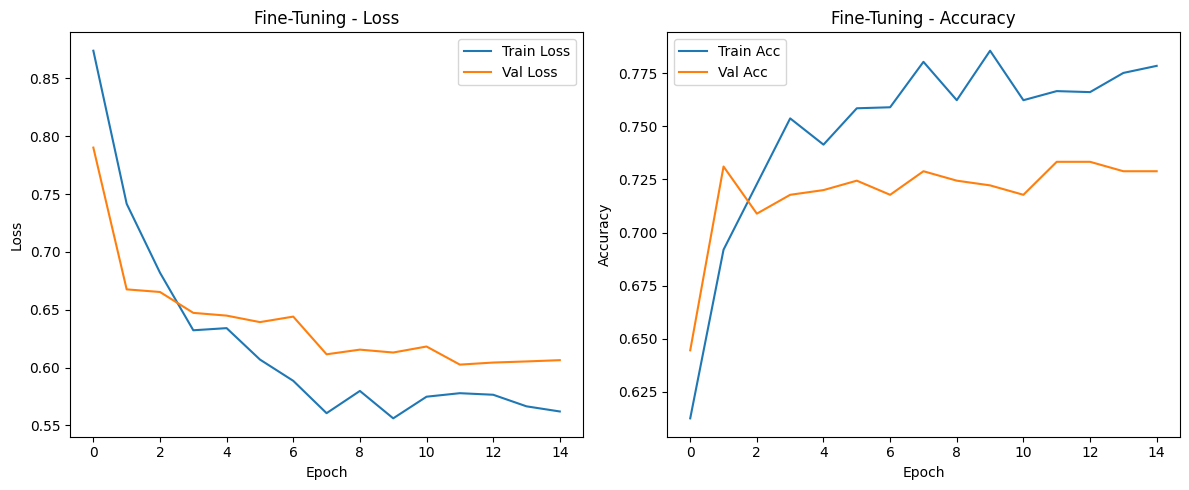

In [10]:
model_fine_tuned = model_ft # Use the pre-trained model instance
criterion_ft = nn.CrossEntropyLoss()
params_to_update_ft = [p for p in model_fine_tuned.parameters() if p.requires_grad]
print(f"Optimizing {len(params_to_update_ft)} parameter tensors.")
optimizer_ft = optim.Adam(params_to_update_ft, lr=0.001)
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs_ft = 15
model_fine_tuned, history_ft = train_model(
    model_fine_tuned, criterion_ft, optimizer_ft, exp_lr_scheduler_ft,
    dataloaders, dataset_sizes, device, num_epochs=num_epochs_ft
)

def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'{title} - Loss'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc'); plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'{title} - Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

plot_history(history_ft, "Fine-Tuning")


Evaluating model on 450 samples...

Evaluation Accuracy: 0.7978

Classification Report:
                precision    recall  f1-score   support

Abnormal_Sperm     0.7012    0.8099    0.7516       142
     Non-Sperm     0.8986    0.8210    0.8581       162
  Normal_Sperm     0.8043    0.7603    0.7817       146

      accuracy                         0.7978       450
     macro avg     0.8014    0.7970    0.7971       450
  weighted avg     0.8058    0.7978    0.7997       450



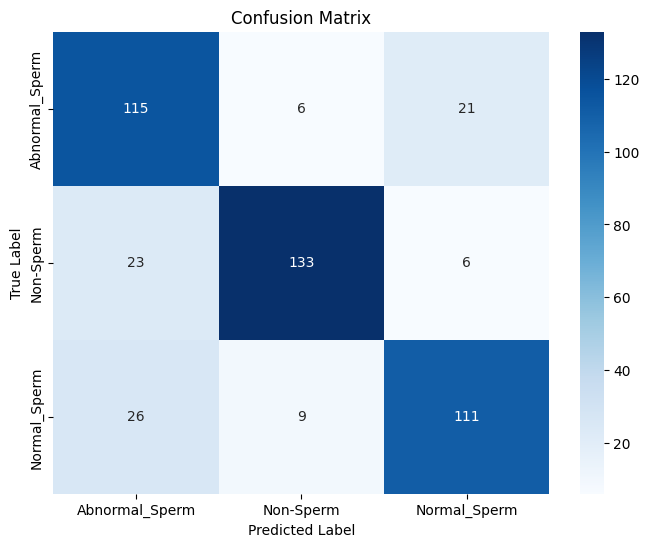

In [11]:
results = {} # Dictionary to store results
if 'model_fine_tuned' in locals():
    accuracy_ft, report_ft, cm_ft = evaluate_model(
        model_fine_tuned, dataloaders['test'], device, class_names
    )
    results['not_really_fine_tuned'] = {'accuracy': accuracy_ft, 'report': report_ft, 'cm': cm_ft}

### 2. Baseline (модель з нуля для порівняння)

Використовуємо модель ResNet18 з випадково ініціалізованими вагами (model_scratch) і навчаємо всі її шари на нашому датасеті.


Starting training for 15 epochs...
Epoch 0/14
----------
Train Loss: 0.8065 Acc: 0.6581
Val Loss: 0.7113 Acc: 0.6933
  >> New best validation accuracy: 0.6933

Epoch 1/14
----------
Train Loss: 0.6491 Acc: 0.7467
Val Loss: 0.6343 Acc: 0.7711
  >> New best validation accuracy: 0.7711

Epoch 2/14
----------
Train Loss: 0.5856 Acc: 0.7776
Val Loss: 0.6034 Acc: 0.7622

Epoch 3/14
----------
Train Loss: 0.5803 Acc: 0.7752
Val Loss: 0.5538 Acc: 0.7689

Epoch 4/14
----------
Train Loss: 0.5590 Acc: 0.7776
Val Loss: 0.6379 Acc: 0.7356

Epoch 5/14
----------
Train Loss: 0.5516 Acc: 0.7810
Val Loss: 0.7665 Acc: 0.6978

Epoch 6/14
----------
Train Loss: 0.5341 Acc: 0.7990
Val Loss: 0.5731 Acc: 0.7578

Epoch 7/14
----------
Train Loss: 0.5268 Acc: 0.8043
Val Loss: 0.8825 Acc: 0.6844

Epoch 8/14
----------
Train Loss: 0.5071 Acc: 0.8010
Val Loss: 0.5308 Acc: 0.7956
  >> New best validation accuracy: 0.7956

Epoch 9/14
----------
Train Loss: 0.4772 Acc: 0.8138
Val Loss: 0.4728 Acc: 0.8067
  >> New 

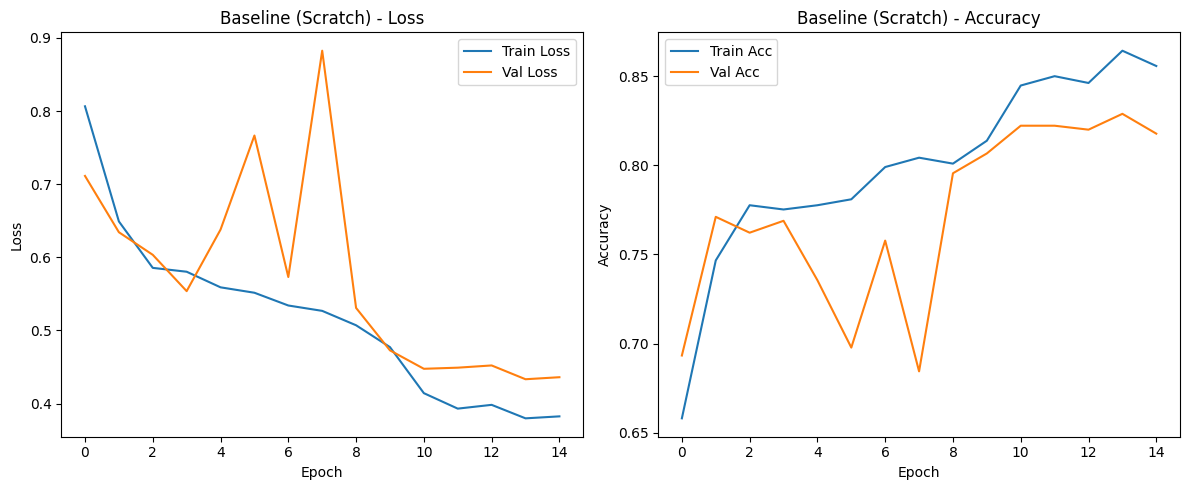

In [12]:
model_baseline = model_scratch # Use the scratch model instance
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model_baseline.parameters(), lr=0.001) # Optimize all params
exp_lr_scheduler_scratch = lr_scheduler.StepLR(optimizer_scratch, step_size=10, gamma=0.1)

num_epochs_scratch = 15
model_baseline, history_scratch = train_model(
    model_baseline, criterion_scratch, optimizer_scratch, exp_lr_scheduler_scratch,
    dataloaders, dataset_sizes, device, num_epochs=num_epochs_scratch
)

plot_history(history_scratch, "Baseline (Scratch)")


Evaluating model on 450 samples...

Evaluation Accuracy: 0.8489

Classification Report:
                precision    recall  f1-score   support

Abnormal_Sperm     0.8296    0.7887    0.8087       142
     Non-Sperm     0.8931    0.8765    0.8847       162
  Normal_Sperm     0.8205    0.8767    0.8477       146

      accuracy                         0.8489       450
     macro avg     0.8477    0.8473    0.8470       450
  weighted avg     0.8495    0.8489    0.8487       450



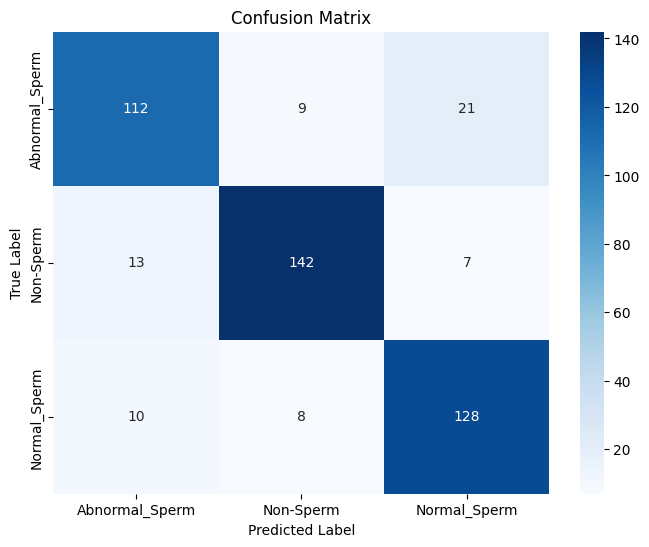

In [13]:
if 'model_baseline' in locals():
    accuracy_scratch, report_scratch, cm_scratch = evaluate_model(
        model_baseline, dataloaders['test'], device, class_names
    )
    results['scratch'] = {'accuracy': accuracy_scratch, 'report': report_scratch, 'cm': cm_scratch}

### 3. Налаштування Fine-tuning

Завантажую свіжий переднавчений екземпляр ResNet18 і заморожую всі шари, крім останнього згорткового блоку (layer4) та фінального класифікаційного шару (fc). 
Налаштовуємо оптимізатор Adam з різними швидкостями навчання (learning rates) для цих двох груп параметрів (менша для layer4, більша для fc) -> це буде саме робочий файн тюнинг

In [14]:
model_ft_full, _ = setup_model(num_classes, pretrained=True, feature_extract=False)
model_ft_full = model_ft_full.to(device)

criterion_ft_full = nn.CrossEntropyLoss()

params_to_update_fc = model_ft_full.fc.parameters()
params_to_update_conv = model_ft_full.layer4.parameters()

for param in model_ft_full.parameters():
    param.requires_grad = False
for param in model_ft_full.layer4.parameters():
    param.requires_grad = True
for param in model_ft_full.fc.parameters():
    param.requires_grad = True

print("Parameters to optimize:")
total_params = 0
trainable_params = 0
for name, param in model_ft_full.named_parameters():
     total_params += param.numel()
     if param.requires_grad:
         print(f"  Trainable: {name}")
         trainable_params += param.numel()

print(f"\nTotal parameters: {total_params}")
print(f"Trainable parameters (layer4 + fc): {trainable_params}")

optimizer_ft_full = optim.Adam([
    {'params': params_to_update_conv, 'lr': 0.0001},
    {'params': params_to_update_fc, 'lr': 0.001}
], lr=0.001)

exp_lr_scheduler_ft_full = lr_scheduler.StepLR(optimizer_ft_full, step_size=7, gamma=0.1)


Loading PRE-TRAINED ResNet18.
Unfreezing ALL parameters for full fine-tuning.
Replaced final layer: Linear(512, 3).
Parameters to optimize:
  Trainable: layer4.0.conv1.weight
  Trainable: layer4.0.bn1.weight
  Trainable: layer4.0.bn1.bias
  Trainable: layer4.0.conv2.weight
  Trainable: layer4.0.bn2.weight
  Trainable: layer4.0.bn2.bias
  Trainable: layer4.0.downsample.0.weight
  Trainable: layer4.0.downsample.1.weight
  Trainable: layer4.0.downsample.1.bias
  Trainable: layer4.1.conv1.weight
  Trainable: layer4.1.bn1.weight
  Trainable: layer4.1.bn1.bias
  Trainable: layer4.1.conv2.weight
  Trainable: layer4.1.bn2.weight
  Trainable: layer4.1.bn2.bias
  Trainable: fc.weight
  Trainable: fc.bias

Total parameters: 11178051
Trainable parameters (layer4 + fc): 8395267


Донавчання даних леєрів


Starting training for 15 epochs...
Epoch 0/14
----------
Train Loss: 0.5697 Acc: 0.7538
Val Loss: 0.4087 Acc: 0.8333
  >> New best validation accuracy: 0.8333

Epoch 1/14
----------
Train Loss: 0.3591 Acc: 0.8519
Val Loss: 0.3797 Acc: 0.8511
  >> New best validation accuracy: 0.8511

Epoch 2/14
----------
Train Loss: 0.3268 Acc: 0.8724
Val Loss: 0.4179 Acc: 0.8311

Epoch 3/14
----------
Train Loss: 0.2588 Acc: 0.8910
Val Loss: 0.4001 Acc: 0.8489

Epoch 4/14
----------
Train Loss: 0.2577 Acc: 0.8957
Val Loss: 0.4247 Acc: 0.8444

Epoch 5/14
----------
Train Loss: 0.1863 Acc: 0.9310
Val Loss: 0.4131 Acc: 0.8333

Epoch 6/14
----------
Train Loss: 0.1774 Acc: 0.9338
Val Loss: 0.4164 Acc: 0.8556
  >> New best validation accuracy: 0.8556

Epoch 7/14
----------
Train Loss: 0.1468 Acc: 0.9467
Val Loss: 0.3675 Acc: 0.8756
  >> New best validation accuracy: 0.8756

Epoch 8/14
----------
Train Loss: 0.1120 Acc: 0.9595
Val Loss: 0.3659 Acc: 0.8689

Epoch 9/14
----------
Train Loss: 0.1002 Acc: 0.9

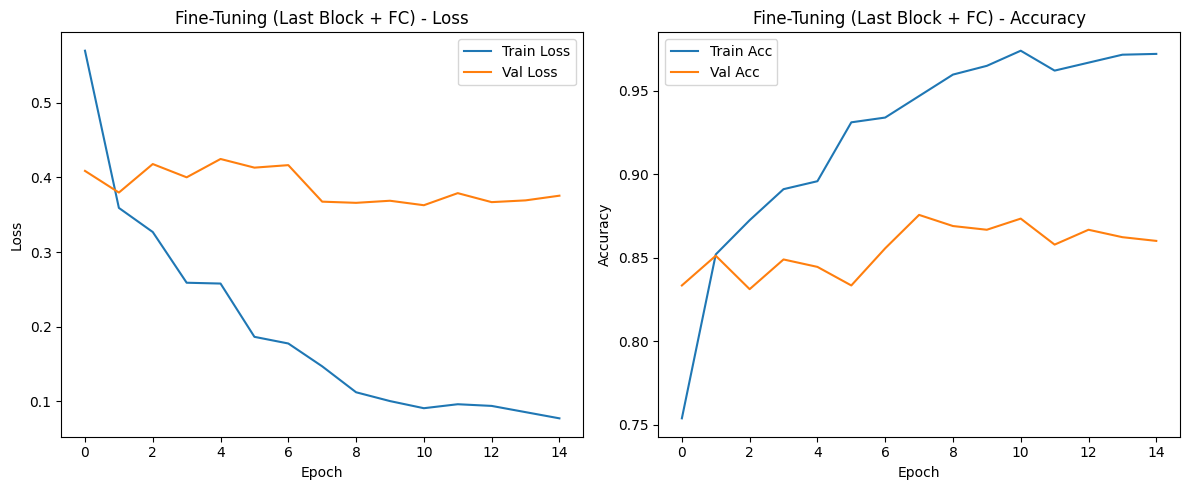

In [15]:
num_epochs_ft_full = 15

model_ft_full_trained, history_ft_full = train_model(
    model_ft_full,
    criterion_ft_full,
    optimizer_ft_full,
    exp_lr_scheduler_ft_full,
    dataloaders,
    dataset_sizes,
    device,
    num_epochs=num_epochs_ft_full
)
print("\nFine-tuning (Last Block + FC) training finished.")

plot_history(history_ft_full, "Fine-Tuning (Last Block + FC)")


Evaluating model on 450 samples...

Evaluation Accuracy: 0.8867

Classification Report:
                precision    recall  f1-score   support

Abnormal_Sperm     0.8380    0.8380    0.8380       142
     Non-Sperm     0.9605    0.9012    0.9299       162
  Normal_Sperm     0.8590    0.9178    0.8874       146

      accuracy                         0.8867       450
     macro avg     0.8858    0.8857    0.8851       450
  weighted avg     0.8889    0.8867    0.8871       450



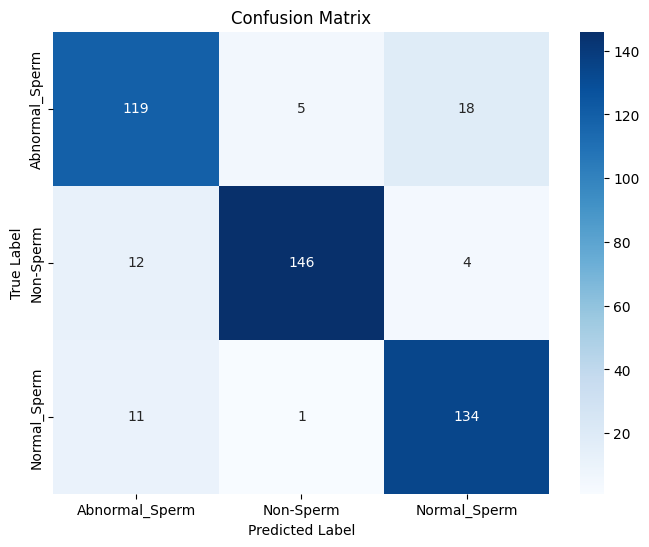

In [16]:
if 'model_ft_full_trained' in locals():
    accuracy_ft_full, report_ft_full, cm_ft_full = evaluate_model(
        model_ft_full_trained,
        dataloaders['test'],
        device,
        class_names
    )
    results['fine_tuned_full'] = {'accuracy': accuracy_ft_full, 'report': report_ft_full, 'cm': cm_ft_full}

In [17]:
ft_extract_results = results.get('not_really_fine_tuned')
sc_results = results.get('scratch')
ft_full_results = results.get('fine_tuned_full')

print("\nMethod 1: Feature Extraction (FT Extract):")
print(f"  Test Accuracy: {ft_extract_results['accuracy']:.4f}")

print("\nMethod 2: Baseline (From Scratch train last layer):")
print(f"  Test Accuracy: {sc_results['accuracy']:.4f}")

print("\nMethod 3: Fine-Tuning (Last Block + FC):")
print(f"  Test Accuracy: {ft_full_results['accuracy']:.4f}")


Method 1: Feature Extraction (FT Extract):
  Test Accuracy: 0.7978

Method 2: Baseline (From Scratch train last layer):
  Test Accuracy: 0.8489

Method 3: Fine-Tuning (Last Block + FC):
  Test Accuracy: 0.8867


## Висновки
1. Той факт, що модель, навчена з нуля, показала кращий результат, ніж простий Feature Extraction (де тренувався лише останній шар), свідчить про значну "різницю доменів". Зображення морфології присутніх об'єктів візуально сильно відрізняються від загальних об'єктів у датасеті ImageNet. Тому готові ознаки з ImageNet виявилися менш ефективними, ніж ознаки, вивчені спеціально для цього завдання з нуля.
2. Fine tuning вдало поєднав переваги обох підходів - почав з корисних загальних ознак, вивчених на ImageNet, виконав адаптування ключові шари для виділення ознак.